# Lab 5: Non-negative Matrix Factorization

The goal of this lab session is to code a NMF algorithm and use it in some applications.

You have to send the filled notebook named **"L5_familyname1_familyname2.ipynb"** (groups of 2) by email to *violeta.roizman@l2s.centralesupelec.fr* by October 31, 2018 and put **"AML-L5"** in the subject. 

We begin with the standard imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

## NMF

Non-negative Matrix Factorization is a model where a matrix V is factorized into two matrices W and H, with the property that all three matrices have no negative elements. This non-negativity makes the resulting matrices easier to interpret.

Fill in the following class that implements a NMF by multiplicative updates using the Frobenius norm or the Kullback-Leiber divergence as loss function (implement both). Try 10 different random initializations and choose the best one.

In [3]:
class my_NMF():
    
    def __init__(self, n_components, loss, epsilon, max_iter = 60):
        '''
        Attributes:
        
        n_components_ : integer
            the unknown dimension of W and H
        max_iter_: integer
            maximum number of iterations
        epsilon_: float
            convergence
        loss_ = {"Frobenius", "KL"}
        W_: np.array
            W Matrix factor
        H_: np.array
            H Matrix factor
        '''
        self.n_components_ = n_components
        self.max_iter_ = max_iter
        self.loss_ = loss
        self.epsilon_ = epsilon
        self.W_ = None
        self.H_ = None
        
    def fit_transform(self, X):
        """ Find the factor matrices W and H
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """
        def update(X):
            if self.loss_ == "Frobenius":
                WTX = np.matmul(self.W_.T, X)
                WTWH = np.matmul(np.matmul(self.W_.T, self.W_), self.H_)
                self.H_ =  self.H_*WTX/WTWH
                
                XHT = np.matmul(X, self.H_.T)
                WHHT = np.matmul(self.W_, np.matmul(self.H_, self.H_.T))
                self.W_ = self.W_*XHT/WHHT
            
            elif self.loss == "KL":
                # TODO
                raise RuntimeError("Not implemented yet")
                
            return X - np.matmul(self.W_, self.H_)
                
            
        n, p = X.shape
        self.W_ = np.random.rand(n, self.n_components_)
        self.H_ = np.random.rand(self.n_components_, p)
        
        conv_criteria = True
        n_iter = 0
        
        while conv_criteria and n_iter < self.max_iter_:
            Z = update(X)
            n_iter+=1
            
            if self.loss_=="Frobenius":
                conv_criteria = np.linalg.norm(Z, ord="fro") > self.epsilon_
            elif self.loss_=="KL":
                # TODO
                raise RuntimeError("Not implemented yet")
                
        X_approx = np.matmul(self.W_, self.H_)
        return X_approx

**Bonus (not graded)**: Implement the regularized version

## Applications

### First application

For the first application you are going to analyse the following data to give an interpretation of the factorization:

Apply your NMF algorithm for this dataset and plot the approximated face pictures.

In [4]:
from sklearn.datasets import fetch_olivetti_faces
from skimage.transform import resize

dataset = fetch_olivetti_faces(shuffle=True)

faces = dataset.data
IMAGE_SHAPE = (64, 64)

In [5]:
def gen_random_batch(dataset, batch_size, shape):
    idx = np.random.choice(len(dataset), batch_size)
    faces = [dataset[i].reshape(shape) for i in idx]
    return faces

def plot_comp(comp, ax, title="", label=""):
    vmax = max(comp.max(), -comp.min())
    ax.imshow(comp, cmap=plt.cm.gray, interpolation="nearest", vmin=-vmax, vmax=vmax, label=label)
    ax.set_title(title)
    ax.tick_params(axis='both', labelsize=8)

Influence of `epsilon`

In [6]:
range_epsilon = [10, 1, 1e-2, 1e-6]

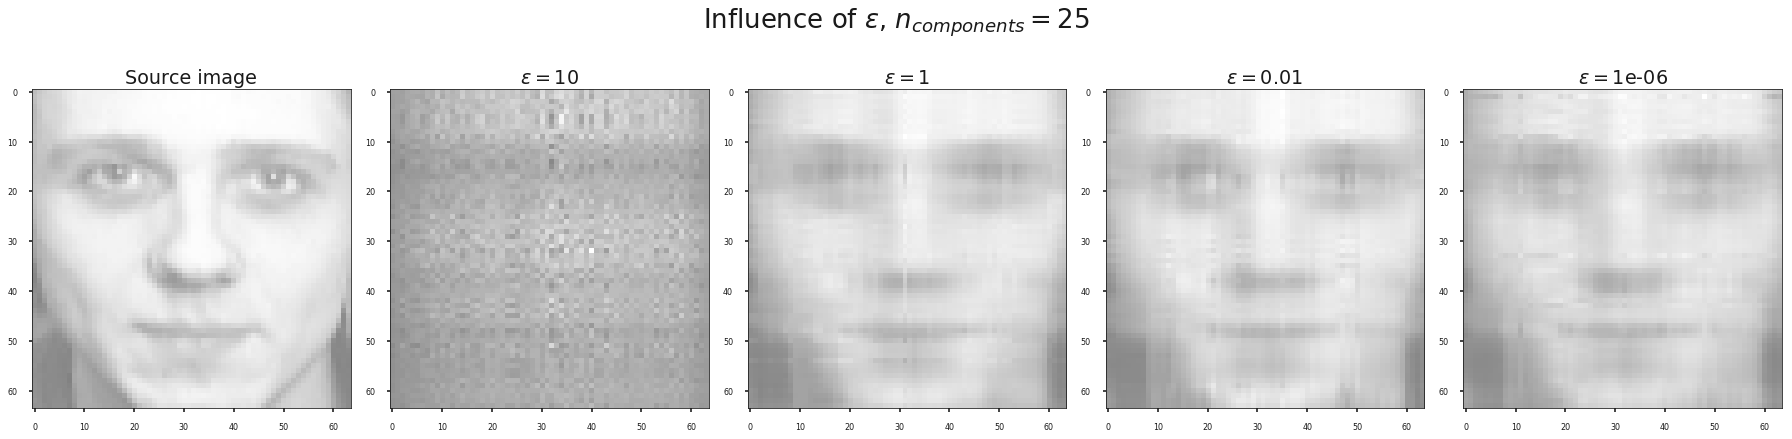

In [7]:
face = gen_random_batch(faces, batch_size=1, shape=IMAGE_SHAPE)

params_set = [{'loss': "Frobenius",
               'n_components': 5,
               'epsilon': eps} for eps in range_epsilon]

n_row = 1
n_col = len(params_set) + 1
fig, ax = plt.subplots(n_row, n_col, figsize=(25, 7))

plot_comp(face[0], ax=ax[0], title="Source image")

for i, params in enumerate(params_set):
    nmf = my_NMF(**params)
    factorised_faces = nmf.fit_transform(face[0])
    
    title = r"$\varepsilon = $" + str(params['epsilon'])
    plot_comp(factorised_faces, ax=ax[i+1], title=title)
    
fig.suptitle(r"Influence of $\varepsilon$, $n_{components}=25$", size=26)
fig.tight_layout()

---

Influence of `n_components`

In [8]:
range_n_components = [1, 9, 16, 25, 49]

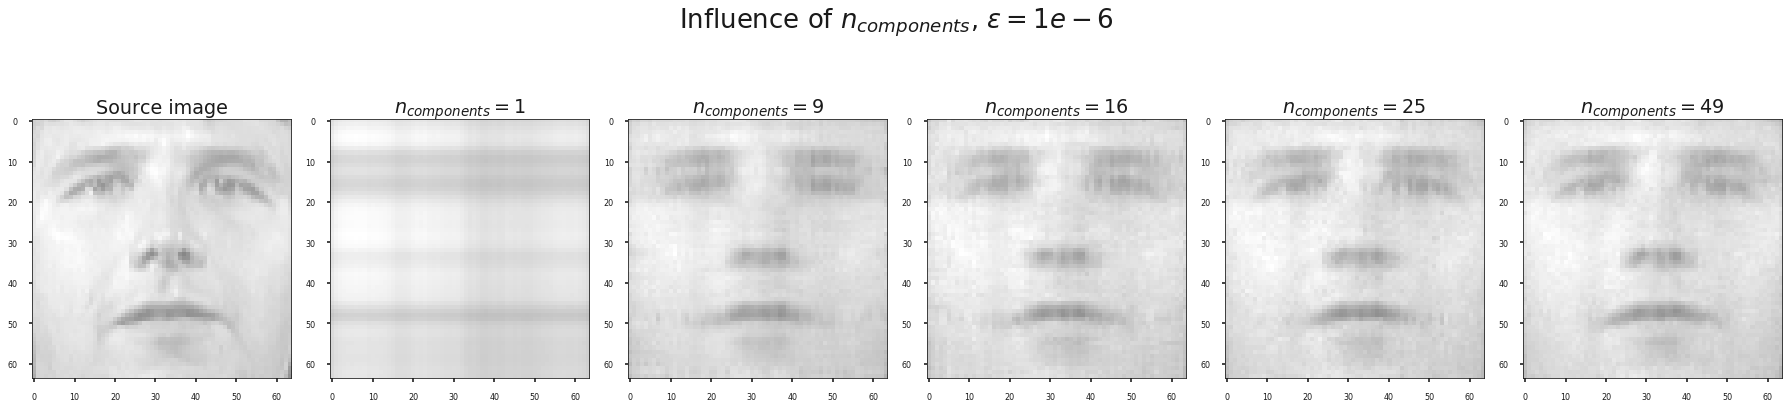

In [9]:
face = gen_random_batch(faces, batch_size=1, shape=IMAGE_SHAPE)

params_set = [{'loss': "Frobenius",
               'n_components': n_components,
               'epsilon': 1e-6} for n_components in range_n_components]

n_row = 1
n_col = len(params_set) + 1
fig, ax = plt.subplots(n_row, n_col, figsize=(len(range_n_components)*5, 7))

plot_comp(face[0], ax=ax[0], title="Source image")

for i, params in enumerate(params_set):
    nmf = my_NMF(**params)
    factorised_faces = nmf.fit_transform(face[0])
    
    title = r"$n_{components} = $" + str(params['n_components'])
    plot_comp(factorised_faces, ax=ax[i+1], title=title)
    
fig.suptitle(r"Influence of $n_{components}$, $\varepsilon=1e-6$", size=26)
fig.tight_layout()

---

- Plot the $W$ matrix as images in a $(\sqrt{r}, \sqrt{r})$ grid
- Choose one face, plot its corresponding weights (in $H$) in a grid  and explain the interpretation of the both factor matrices.

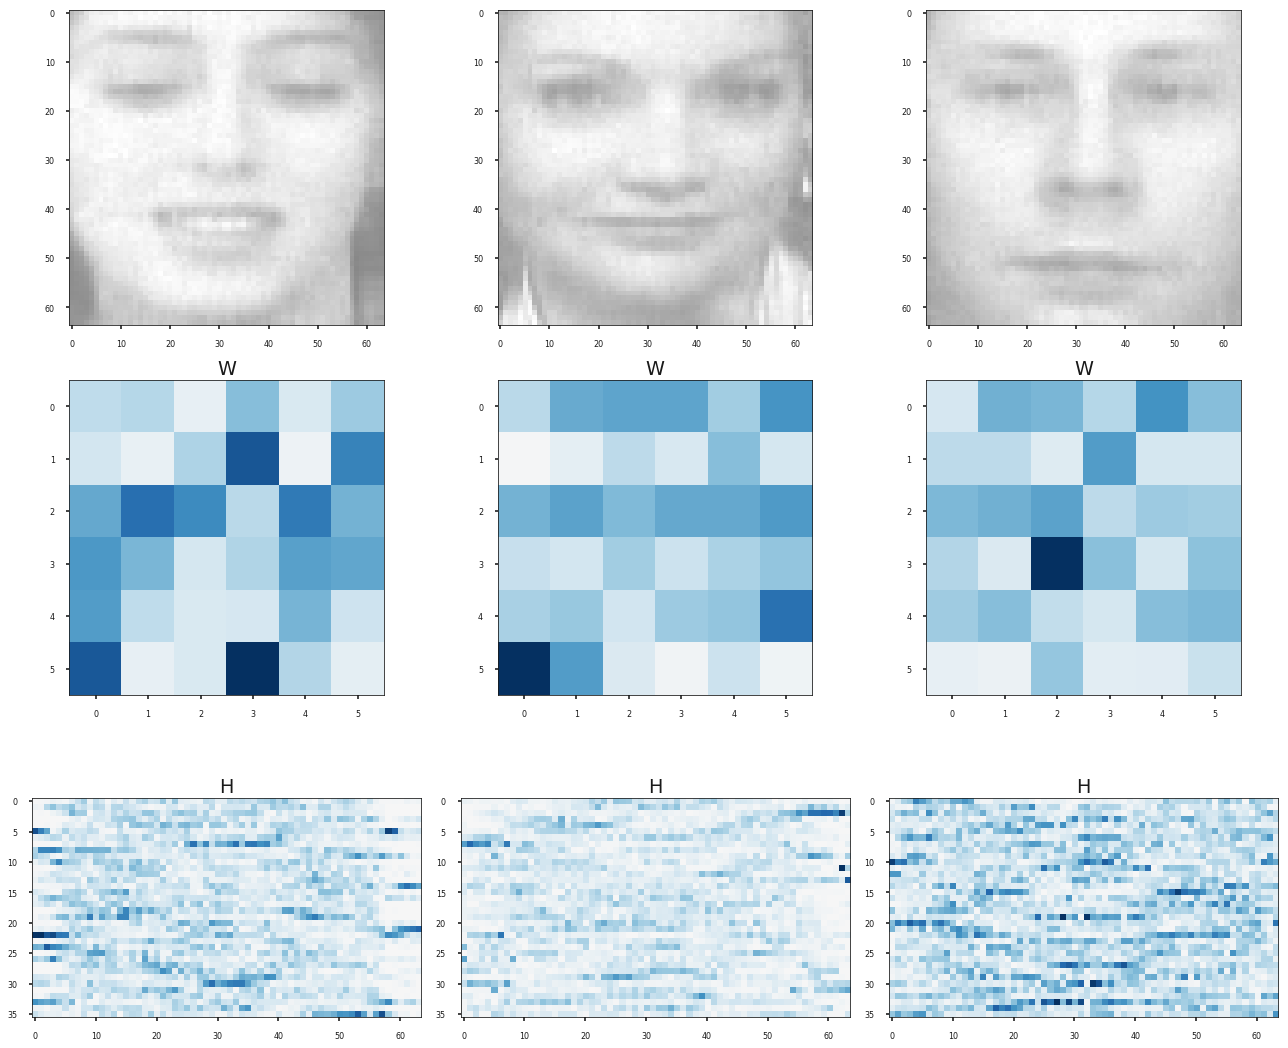

In [14]:
faces_batch = gen_random_batch(faces, batch_size=3, shape=IMAGE_SHAPE)

n_components = 36
sqrt_n_components = int(np.floor(np.sqrt(n_components)))

n_row = 3
n_col = len(faces_batch)

fig, ax = plt.subplots(3, 3, figsize = (18,15))

for i, face in enumerate(faces_batch):
    
    nmf = my_NMF(n_components = n_components, loss="Frobenius", epsilon=1e-6)
    fitted_face = nmf.fit_transform(face.reshape(IMAGE_SHAPE))
    
    comp = fitted_face
    plot_comp(comp, ax=ax[0][i])

    comp = nmf.W_
    comp = resize(nmf.W_, (sqrt_n_components, sqrt_n_components))
    vmax = max(comp.max(), -comp.min())
    ax[1][i].imshow(comp, cmap=plt.cm.RdBu, interpolation="nearest", vmin=-vmax, vmax=vmax)
    ax[1][i].tick_params(axis='both', labelsize=8)
    ax[1][i].set_title("W")

    comp = nmf.H_
    vmax = max(comp.max(), -comp.min())
    ax[2][i].imshow(comp, cmap=plt.cm.RdBu, interpolation="nearest", vmin=-vmax, vmax=vmax)
    ax[2][i].tick_params(axis='both', labelsize=8)
    ax[2][i].set_title("H")

fig.tight_layout()

### Second application

Import the 20newsgroups dataset (from sklearn.datasets import fetch_20newsgroups_vectorized) that contains a collection of ~18,000 newsgroup documents from 20 different newsgroups.

Model the topics present in a subsample with NMF. Print the most common words of each topic.

---

It happens that the `fetch_20newsgroups_vectorized` doesn't hand the vocabulary, so we have to vectorize it ourselves in order to be able to retrieve the word mapped to a given Tfidf vector

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.datasets import fetch_20newsgroups
newsgroups = fetch_20newsgroups()

In [30]:
n_docs = len(newsgroups.data)
n_topics = len(newsgroups.target_names)

print "Corpus size : ", n_docs
print "Nr of topics : ", n_topics

Corpus size :  11314
Nr of topics :  20


Vectorizing the corpus with Tfidf vectorizer, removing stopwords

In [71]:
vectorizer = TfidfVectorizer(max_df=1.5, min_df=2, stop_words='english')
tfidf_vectors = vectorizer.fit_transform(newsgroups.data)

In [72]:
len_vocab = len(vectorizer.vocabulary_)
print "Vocabulary size : ", len_vocab

Vocabulary size :  56126


Fit NMF model

In [84]:
tfidf_nmf = NMF(n_components=n_topics).fit(tfidf_vectors)

In [81]:
for i in range(n_topics):
    print "Topic " + str(i+1)
    top_words = ' - '.join([vectorizer.get_feature_names()[j] for j in np.argsort(tfidf_nmf.components_[i])[:-5:-1]])
    print top_words.encode("utf8")
    print ""

Topic 0
ca - team - game - hockey

Topic 1
god - jesus - bible - christians

Topic 2
key - clipper - encryption - chip

Topic 3
windows - window - dos - file

Topic 4
pitt - geb - gordon - banks

Topic 5
edu - university - cs - posting

Topic 6
com - netcom - hp - article

Topic 7
people - don - gun - think

Topic 8
nasa - gov - space - henry

Topic 9
scsi - drive - ide - controller

Topic 10
keith - caltech - livesey - sgi

Topic 11
israel - israeli - jews - arab

Topic 12
armenian - turkish - armenians - armenia

Topic 13
ohio - state - magnus - acs

Topic 14
uk - ac - __ - ___

Topic 15
sandvik - apple - kent - newton

Topic 16
cleveland - cwru - freenet - reserve

Topic 17
columbia - gld - cc - cunixb

Topic 18
access - digex - pat - net

Topic 19
stratus - sw - cdt - fbi



__Top words per topic visualization__

In [82]:
from sklearn.manifold import TSNE

In [120]:
n_tops = 5

# indexes of top words by topic
vectors_idx = np.array([np.argsort(component)[:-n_tops-1:-1] for component in tfidf_nmf.components_]).flatten()

# corresponding word
vector_label = [vectorizer.get_feature_names()[j] for j in vectors_idx]

# correspongin tfidf vector
vectors_set = np.array([tfidf_nmf.components_.T[j] for j in vectors_idx])

In [130]:
tsne = TSNE(n_components=2)
X = tsne.fit_transform(vectors_set)

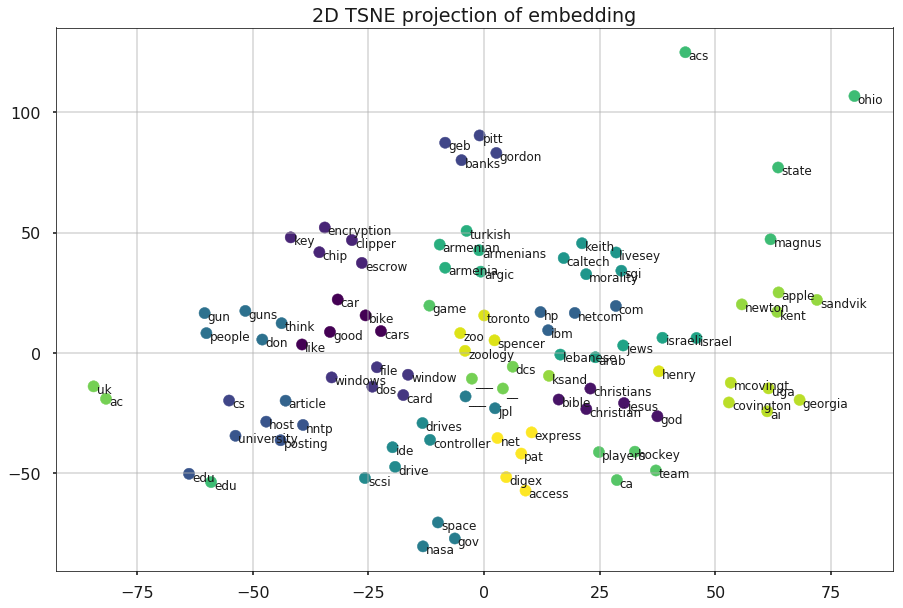

In [134]:
topic = np.repeat(range(n_topics), n_tops)
xs = X[:, 0]
ys = X[:, 1]

plt.figure(figsize=(15,10))
plt.title("2D TSNE plot of embeddings")
plt.grid(alpha = 0.5)
plt.scatter(xs, ys, marker = 'o', c = topic)
for i, word in enumerate(vector_label):
    plt.annotate(word.decode('utf-8', 'ignore'),xy = (xs[i], ys[i]), xytext = (3, 3),textcoords = 'offset points', ha = 'left', va = 'top',fontsize = 12)
plt.show()